In [209]:
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio.features import shapes
import matplotlib.pyplot as plt
import rioxarray as rxr
import os

In [206]:
def get_worldclim_data(file_path, plot=False):
    dataarray = rxr.open_rasterio(file_path)
    df = dataarray[0].to_pandas()
    
    if plot:
        fig, ax = plt.subplots(figsize=(16, 5))
        
        # masking values
        df_masked = np.ma.masked_where((-273 > df), df)
        
        # set axis
        x_min = round((df.columns).min())
        x_max = round((df.columns).max())
        y_min = round((df.index).min())
        y_max = round((df.index).max())

        # use imshow so that we have something to map the colorbar to
        image = ax.imshow(df_masked,
                          extent=[x_min, x_max, y_min, y_max])

        # add colorbar using the now hidden image
        fig.colorbar(image, ax=ax)
        plt.show()
    
    df = df.unstack(level=-1)
    df = df.reset_index()
    df.columns = ['longtitude', 'latitude', 'val']
    return df

In [213]:
file_path = '../raw_data/wc2.1_30s_bio/wc2.1_30s_bio_1.tif'

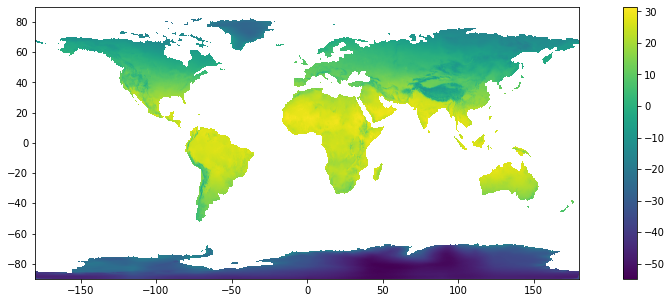

,longtitude,latitude,val
0,-179.995833,89.995833,-3.400000e+38
1,-179.995833,89.987500,-3.400000e+38
2,-179.995833,89.979167,-3.400000e+38
3,-179.995833,89.970833,-3.400000e+38
4,-179.995833,89.962500,-3.400000e+38
...,...,...,...
933119995,179.995833,-89.962500,-2.988333e+01
933119996,179.995833,-89.970833,-2.989167e+01
933119997,179.995833,-89.979167,-2.989167e+01
933119998,179.995833,-89.987500,0.000000e+00


In [214]:
get_worldclim_data(file_path, plot=True)

In [ ]:
def get_worldclim_all(folder_path):
    

In [210]:
os.listdir('../raw_data/wc2.1_10m_bio')

['wc2.1_10m_bio_18.tif',
 'wc2.1_10m_bio_19.tif',
 'wc2.1_10m_bio_8.tif',
 'wc2.1_10m_bio_9.tif',
 'wc2.1_10m_bio_2.tif',
 'wc2.1_10m_bio_3.tif',
 'wc2.1_10m_bio_1.tif',
 'wc2.1_10m_bio_4.tif',
 'wc2.1_10m_bio_5.tif',
 'wc2.1_10m_bio_7.tif',
 'wc2.1_10m_bio_6.tif',
 'wc2.1_10m_bio_11.tif',
 'wc2.1_10m_bio_10.tif',
 'wc2.1_10m_bio_12.tif',
 'wc2.1_10m_bio_13.tif',
 'wc2.1_10m_bio_17.tif',
 'wc2.1_10m_bio_16.tif',
 'wc2.1_10m_bio_14.tif',
 'wc2.1_10m_bio_15.tif']